In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import worldvocoder as wv
import librosa
import IPython

import dtw

import plotly.graph_objects as go
import plotly.express as px

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
# 音声ファイル "boin8k.wav" を読み込む
# yAiueo: 時系列の波形データ（1次元 numpy 配列）
# sr    : サンプリング周波数 [Hz]（ここではファイルに記録されている元の値をそのまま使うため sr=None）
yAiueo, sr = librosa.load("boin8k.wav", sr=None)

# Plotly（go = plotly.graph_objects）を用いて波形を可視化する
# y 引数に波形データを渡し、mode='lines+markers' とすることで
# 「線グラフ＋サンプル点にマーカー」を同時に描画している
fig = go.Figure(
    go.Scatter(
        y=yAiueo,  # 縦軸にプロットする振幅値（時間方向はインデックスで暗黙に表現）
        mode="lines+markers",  # 線と点の両方を表示して波形の細かな変化を見やすくする
    )
)

# Jupyter / Colab 等で図を表示するために show() を呼び出す
fig.show()

In [5]:
# すでに読み込んだ母音波形 yAiueo（例: /a/）から，
# 1周期分と思われる区間だけを切り出す。
# ここではサンプルインデックス 7075〜7124 の 50 サンプルを取り出している。
# pA: 1周期分の波形（周期波のテンプレート）
pA = yAiueo[7075:7125]

# 基本周波数 fo [Hz] を，サンプリング周波数 sr と 1周期のサンプル数から求める。
# 連続時間で考えると，周期 T は
#   T = len(pA) / sr [秒]
# なので，基本周波数 fo は
#   fo = 1 / T = sr / len(pA) [Hz]
# となる。
fo = sr / len(pA)
print("fo = ", fo)

# 合成したい音節全体の長さ（継続時間）を秒単位で指定する。
# ここでは 0.5 秒ぶんの /a/ を合成することを想定している。
durSyllable = 0.5

# 0.5 秒の中に何周期ぶんの波形を敷き詰めるかを計算する。
# 周期数 nPeriod は
#   nPeriod = fo * durSyllable
# が理論式であり，「周波数 × 時間 = 周期数」を表している。
# int() で整数にしているのは，実際にタイル複製する回数は
# サンプル単位で整数回でなければならないため。
nPeriod = int(fo * durSyllable)

# 1周期波形 pA を nPeriod 回だけ並べて結合し，
# 0.5 秒程度の持続音を合成する。
# np.tile(pA, nPeriod) は [pA, pA, ..., pA]（nPeriod 回）を連結した
# 新しい 1 次元配列を返す。
synth_a = np.tile(pA, nPeriod)

# IPython.display.Audio を使って，合成した波形をインタラクティブに再生する。
# rate=sr により，もともとのサンプリング周波数で再生する。
IPython.display.Audio(synth_a, rate=sr)

fo =  160.0


In [6]:
# 低めの基本周波数 foLow [Hz] を設定する。
# ここでは 120 Hz の定常母音を合成したい，という想定になっている。
foLow = 120

# その基本周波数 foLow に対応する 1周期のサンプル数 nLow を計算する。
# 周期 T は
#   T = 1 / foLow [秒]
# したがって 1周期分のサンプル数は
#   nLow = T * sr = sr / foLow
# となる。int() で整数に丸めて，実際の配列長として扱えるようにする。
nLow = int(sr / foLow)

# pA は元々の 1周期分の波形（len(pA) サンプル）であり，
# これを「基本周波数 foLow 用の 1周期波形」に変換したい。
# 低い周波数にするということは，1周期の時間を長くする = 1周期あたりのサンプル数を増やすことに相当する。
# そこで，pA の後ろに 0 を詰めて長さを nLow まで引き伸ばし，
# 波形形状は先頭の pA に従いつつも，全体の周期長だけを伸ばした 1周期波形を作る。
one_period_low = np.hstack((pA, np.zeros(nLow - len(pA))))

# 0.5 秒間ぶんの周期数は
#   foLow * durSyllable
# 周波数 [Hz] × 時間 [s] = 周期数
# となるので，その整数部分だけ 1周期波形を繰り返して連結する。
# np.tile(one_period_low, 回数) によって，
# [one_period_low, one_period_low, ..., one_period_low] を並べた波形が得られる。
wave_low = np.tile(one_period_low, int(foLow * durSyllable))

# 合成した低周波数版の母音波形 wave_low を再生する。
# rate=sr によって，もともとのサンプリング周波数で再生される。
IPython.display.Audio(wave_low, rate=sr)

In [7]:
# yAiueo から別の母音 /i/ の 1周期分らしき区間を切り出す。
# pA が /a/ の 1周期波形だったのに対し，pI は /i/ の 1周期波形に相当する想定。
pI = yAiueo[15043:15090]

# /a/ と /i/ のどちらの周期長にも対応できるように，
# 周期長 nVowel を「pA と pI のうち長い方のサンプル数」として定義する。
# これにより，短い方はゼロ詰めで拡張し，周期長を揃えられる。
nVowel = max(len(pA), len(pI))

# 母音遷移（/a/ → /i/ のクロスフェード）にかける時間 [秒] を設定する。
durTrans = 0.1  # ここでは 0.1 秒で /a/ から /i/ に滑らかに変化させる

# 遷移に使う周期の数 nPeriodTrans を決める。
# 「遷移に使いたい時間 durTrans」を，「1周期あたりの長さ（nVowel サンプル）」で割ることで，
# durTrans 内に何周期ぶん収まるかを求めている。
#   durTrans [s] × sr [samples/s] / nVowel [samples/period]
# = durTrans × sr / nVowel [periods]
nPeriodTrans = int(sr * durTrans / nVowel)

# /a/ の 1周期波形 unitA を作る。
# pA はもともと len(pA) サンプルしかないので，nVowel まで 0 でパディングして周期長を揃える。
unitA = np.hstack((pA.T, np.zeros(nVowel - len(pA))))
# さらに，後で波形を足し合わせるとクリッピングしやすくなるので，
# 振幅の最大絶対値で割って [-1, 1] 程度になるよう正規化しておく。
unitA = unitA / np.max(np.abs(unitA))

# /i/ の 1周期波形 unitI も同様に作る。
unitI = np.hstack((pI.T, np.zeros(nVowel - len(pI))))
unitI = unitI / np.max(np.abs(unitI))

# /a/ から /i/ へのクロスフェードに使うエンベロープを作る。
# nVowel * nPeriodTrans サンプルぶんの線形な減衰・増加カーブを用意する。
# down は 1 → 0（/a/ のゲイン），up は 0 → 1（/i/ のゲイン）である。
down = np.linspace(1, 0, nVowel * nPeriodTrans)  # /a/ の重み：時間とともに 1 から 0 へ
up = np.linspace(0, 1, nVowel * nPeriodTrans)  # /i/ の重み：時間とともに 0 から 1 へ

# ySynthAI 全体の構成は次の 3 部分の連結になっている：
#  1. /a/ の純粋な繰り返し部分（遷移前）
#  2. /a/ と /i/ を crossfade する遷移部分
#  3. /i/ の純粋な繰り返し部分（遷移後）

# 1. 遷移に使う nPeriodTrans 周期を除いた分だけ，
#    /a/ の 1周期波形 unitA を繰り返して連結する（遷移前の /a/ 維持部分）。
part_A = np.tile(unitA, nPeriod - nPeriodTrans)

# 2. 遷移部分：
#    - /a/ の周期波形 unitA を nPeriodTrans 回だけ繰り返した波形
#    - /i/ の周期波形 unitI を nPeriodTrans 回だけ繰り返した波形
#    に対して，それぞれ down（1→0）と up（0→1）のエンベロープをかけて足し合わせる。
#    これにより，時間が進むにつれ /a/ の寄与が減り，/i/ の寄与が増えるクロスフェードが実現される。
part_trans = np.tile(unitA, nPeriodTrans) * down + np.tile(unitI, nPeriodTrans) * up

# 3. 遷移後の /i/ 維持部分：
#    遷移に使った nPeriodTrans 周期を除いた分だけ /i/ の周期波形を繰り返す。
part_I = np.tile(unitI, nPeriod - nPeriodTrans)

# 3 つの区間を時間順に連結して，/a/ → /i/ への連続的な母音遷移波形 ySynthAI を作る。
ySynthAI = np.hstack((part_A, part_trans, part_I))

# 合成した /a/ から /i/ への遷移音声を再生する。
IPython.display.Audio(ySynthAI, rate=sr)

In [8]:
# /ka/ の子音部（破裂音 /k/）を含む音声ファイルを読み込む。
# sr はすでに前段で使っているサンプリング周波数（例: 48000 Hz, 16000 Hz など）を再利用する。
yKa, _ = librosa.load("ka48k.wav", sr=sr)

# 読み込んだ /ka/ の波形を，プロットで確認する。
# Plotly を用いて「サンプルインデックス vs 振幅」の折れ線＋マーカーとして可視化している。
go.Figure(go.Scatter(y=yKa, mode="lines+markers"))

# 波形を正規化する。最大絶対値が 1 になるようにスケーリングし，
# その後の重ね合わせや音量調整時にクリップしにくくする。
yKa = yKa / np.max(np.abs(yKa))

# /k/ 子音部分を 1 つの時間区間として切り出す。
# ここではサンプルインデックス 500〜1204 を「破裂＋摩擦」の区間（子音部）とみなしている。
# pK が「子音 /k/」の短い波形断片として機能する。
pK = yKa[500:1204]

# 前段で定義された nVowel（例: 母音 1周期のサンプル数）を使って，
# 子音末尾と母音頭部をスムーズに接続するためのクロスフェード用エンベロープを作る。
# downC: 1 → 0，子音側のゲイン
downC = np.linspace(1, 0, nVowel)
# upC  : 0 → 1，母音側のゲイン
upC = np.linspace(0, 1, nVowel)

# /ka/ 合成波形 ySynthKa を構成する。
# 構造はおおまかに
#   1. 子音 /k/ の立ち上がり部分（クロスフェードに使う nVowel サンプルより前）
#   2. 子音 /k/ の末尾と母音 /a/ の 1周期 unitA をクロスフェードさせる区間
#   3. 母音 /a/ を複数周期だけ繰り返した持続区間
# という 3 パートの連結になっている。

ySynthKa = np.hstack(
    (
        # 1. 子音だけが鳴っている前半部分：
        #    pK の末尾 nVowel サンプルをクロスフェードに使うので，
        #    それ以前の部分（len(pK) - nVowel サンプル）をそのまま並べる。
        pK[: len(pK) - nVowel],
        # 2. 子音 → 母音への遷移部分：
        #    - pK の末尾 nVowel サンプル（子音終わり部分）に downC（1→0）を掛けて徐々に減衰させる。
        #    - 母音 1周期 unitA に upC（0→1）を掛けて徐々に立ち上げる。
        #    その和を取ることで，時間とともに /k/ から /a/ へ滑らかに音色が変化する。
        pK[-nVowel:] * downC + unitA * upC,
        # 3. 母音 /a/ の持続部分：
        #    unitA（母音 1周期）を繰り返して，子音のあとに母音が伸びているような /ka/ を作る意図。
        #    ここでは np.tile(unitA, nPeriod - nVowel) となっているが，
        #    nPeriod は「周期数」，nVowel は「サンプル数」なので，
        #    次元の意味が異なる点には注意が必要（ここは実験の途中で調整が必要な箇所と思われる）。
        np.tile(unitA, nPeriod - nVowel),
    )
)

# 合成した /ka/ 音声を再生する。
# 破裂子音 /k/ の後に，前段で合成した母音 /a/（unitA）へ連続的に接続した音が聞こえる想定。
IPython.display.Audio(ySynthKa, rate=sr)

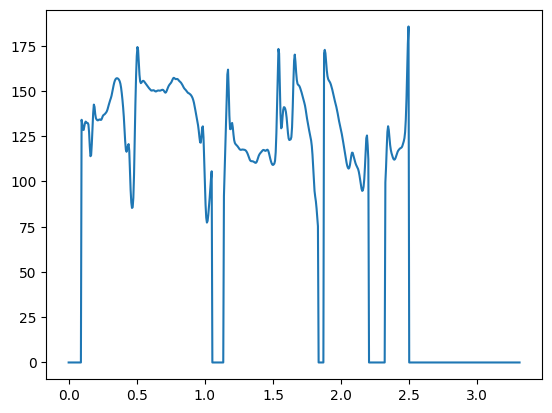

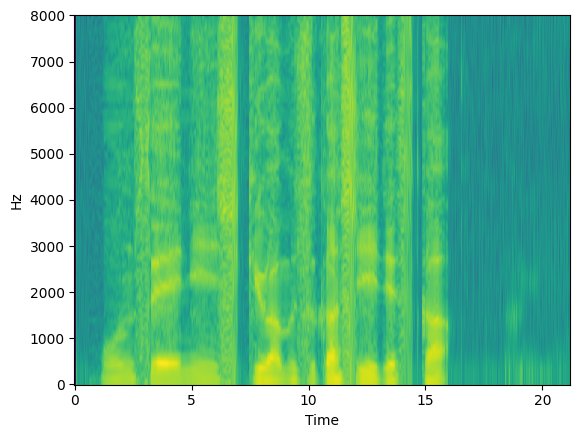

In [10]:
# 音声ファイル（日本語文）を読み込み
# y1 : 音声波形（1 次元 numpy 配列）
# fs1: サンプリング周波数 [Hz]（wav ファイル内の値をそのまま使うため sr=None）
y1, fs1 = librosa.load("ja_sentence.wav", sr=None)

# WORLD ボコーダのインスタンスを作成
# WORLD は「基本周波数 F0」「スペクトル包絡」「非周期成分」の 3 つに分解・合成する高品質ボコーダ
vocoder = wv.World()

# WORLD による分析処理（エンコード）を実行
# - f0_method='harvest' により，F0 抽出アルゴリズムとして HARVEST を使用
#   HARVEST は DIO よりもロバストな F0 抽出を目指した手法
# 返り値 feature1 は dict で，主に以下の情報を含む：
#   feature1['temporal_positions'] : 各フレームの時間位置 [sec]
#   feature1['f0']                 : 各フレームの基本周波数 F0 [Hz]
#   feature1['spectrogram']        : スペクトル包絡（周波数軸 × 時間軸）
#   feature1['aperiodicity']       : 非周期成分（雑音的成分）の情報
feature1 = vocoder.encode(fs1, y1, f0_method="harvest")

# 抽出された F0（基本周波数）の時間変化をプロット
# - temporal_positions を横軸（時間）
# - f0 を縦軸（周波数）として線グラフを描く
# これにより，発話中のピッチ（イントネーション）パターンが確認できる
plt.plot(feature1["temporal_positions"], feature1["f0"])

# 新しい Figure を作成してスペクトログラムを可視化
plt.figure()

# WORLD のスペクトル包絡を dB スケールに変換してスペクトログラム表示
# - feature1['spectrogram'] は振幅スペクトル（あるいはパワー）を持つので，
#   20 * log10(...) により対数振幅 [dB] へ変換している
# - librosa.display.specshow により時間 × 周波数のヒートマップとして描画
#   cmap='viridis' : カラーマップの指定
#   sr=fs1         : サンプリング周波数（時間軸のスケーリングに利用）
#   x_axis='time'  : x 軸を時間 [sec]
#   y_axis='linear': y 軸を線形周波数 [Hz]（対数周波数にしたい場合は 'log' などを指定）
librosa.display.specshow(
    20 * np.log10(feature1["spectrogram"]),
    cmap="viridis",
    sr=fs1,
    x_axis="time",
    y_axis="linear",
)

# 分析したパラメータ（F0・スペクトル包絡・非周期成分）から，
# WORLD ボコーダで音声波形を再合成（デコード）
# - decode は encode の逆変換であり，
#   「分析–合成」のチェーンがどの程度情報損失なく動いているかを確認できる
output1 = vocoder.decode(feature1)

# 再合成された音声を再生
# - output1['out'] に再合成された 1 次元波形が格納されている
# - rate=fs1 で元のサンプリング周波数で再生
# ここで知覚的に「元音声とどれくらい近いか」を聞くことで，
# WORLD による分析・合成の品質を評価できる
IPython.display.Audio(output1["out"], rate=fs1)

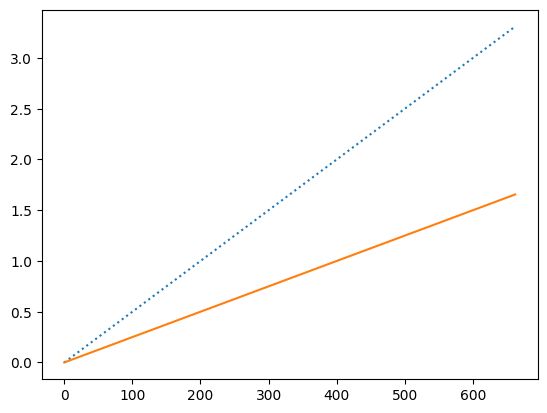

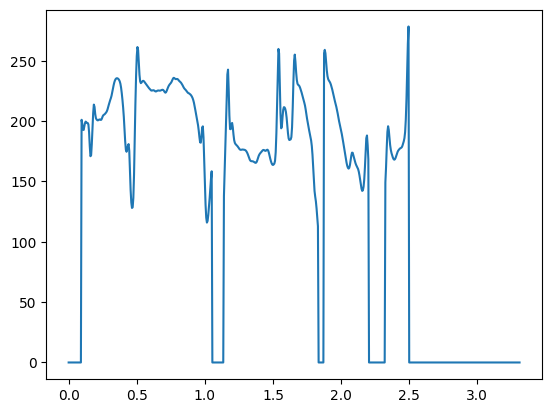

In [11]:
# feature1 をそのまま書き換えると元の分析結果が失われてしまうため，
# copy.deepcopy を使って「完全なコピー」を作る。
# （浅いコピーだと dict 内部の配列を共有してしまい，意図せず元も変わる危険がある）
feature1_1 = copy.deepcopy(feature1)

# 発話の時間スケールを変更（時間伸縮）する
# scale_duration(..., 0.5) は「持続時間を 0.5 倍」にする操作（= 2 倍速再生に相当）
#   temporal_positions が 0.5 倍の範囲に圧縮され，
#   スペクトル系列もそれに合わせて時間方向に詰められる
feature1_1 = vocoder.scale_duration(feature1_1, 0.5)

# 時間伸縮後のパラメータから WORLD で再合成
# duration を変えても F0 やスペクトル包絡の「形」は基本的に保たれるため，
# 高さ・音色はほぼそのままに「速くしゃべっている」ような音になる
output1_1 = vocoder.decode(feature1_1)

# 2 倍速になった音声を再生して確認
IPython.display.display(IPython.display.Audio(output1_1["out"], rate=fs1))

# 元の temporal_positions（時間軸）と，
# duration 変更後の temporal_positions を重ねてプロット
# ':' で元（点線），実線で変更後を描くことで，
# 時間軸がどれくらい圧縮されているかを可視化している
plt.plot(feature1["temporal_positions"], ":")
plt.plot(feature1_1["temporal_positions"])


# ここからは「ピッチ（F0）のスケーリング」による声質変化の実験

# duration のときと同様，元の feature1 を壊さないよう deepcopy する
feature1_2 = copy.deepcopy(feature1)

# ピッチ（基本周波数 F0）を 1.5 倍にスケーリング
# scale_pitch(..., 1.5) は F0 を 1.5 倍にする処理で，
# 一般に「声が高く・明るく」聞こえる方向の変化を与える
# 時間軸（temporal_positions）は変えず，F0 だけを変える点が duration 操作との違い
feature1_2 = vocoder.scale_pitch(feature1_2, 1.5)

# ピッチを上げたパラメータから再合成
output1_2 = vocoder.decode(feature1_2)

# ピッチ変更後の F0 軌跡をプロットして，
# 元よりも全体的に高い値にシフトしていることを確認
plt.figure()
plt.plot(feature1_2["temporal_positions"], feature1_2["f0"])

# ピッチが 1.5 倍になった音声を再生
# 時間長はほぼ元のまま，声の高さだけが変わる（いわゆる「声質変換」の初歩）
IPython.display.Audio(output1_2["out"], rate=fs1)